# **Setup**

In [19]:
import os

from numpy.random import seed
import tensorflow

In [20]:
os.environ['KAGGLE_USERNAME'] = 'rahulsivadasan'
os.environ['KAGGLE_KEY'] ='f28c3ddf72a389462284db371f02fc84'

seed(100)
tensorflow.random.set_seed(100)

# **Helper Functions**




In [31]:
def search_dir(type="normal", num=6):
  #Helper function to scan contents of directory
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [32]:

def plot_images(type="normal", num=6):
  #Helper function to plot images
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [33]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

# **Downloading the Data**


In [13]:
%time !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia 

100% 2.29G/2.29G [00:27<00:00, 150MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.8MB/s]
CPU times: user 200 ms, sys: 71 ms, total: 271 ms
Wall time: 29.3 s


In [14]:
%time !unzip chest-xray-pneumonia.zip 

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xra

# **Data Exploration**



In [34]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [35]:
#Point to the relevant directories
train_dir = "chest_xray/train/"
val_dir   = "chest_xray/test/" #directories for training

test_dir  = "chest_xray/val/" #directory for final model scoring

In [36]:
search_dir(type="pneumonia", num=10)


person326_bacteria_1504.jpeg
person1748_bacteria_4588.jpeg
person422_virus_868.jpeg
person1542_bacteria_4029.jpeg
person319_bacteria_1480.jpeg
person834_bacteria_2748.jpeg
person1366_bacteria_3490.jpeg
person401_virus_798.jpeg
person23_bacteria_93.jpeg
person1344_bacteria_3421.jpeg


In [37]:
search_dir(type="normal", num=10)


IM-0357-0001.jpeg
NORMAL2-IM-0903-0001.jpeg
IM-0519-0001.jpeg
NORMAL2-IM-1089-0001.jpeg
NORMAL2-IM-1163-0001.jpeg
NORMAL2-IM-1277-0001-0001.jpeg
NORMAL2-IM-1201-0001.jpeg
IM-0486-0001.jpeg
IM-0140-0001.jpeg
NORMAL2-IM-0533-0001.jpeg


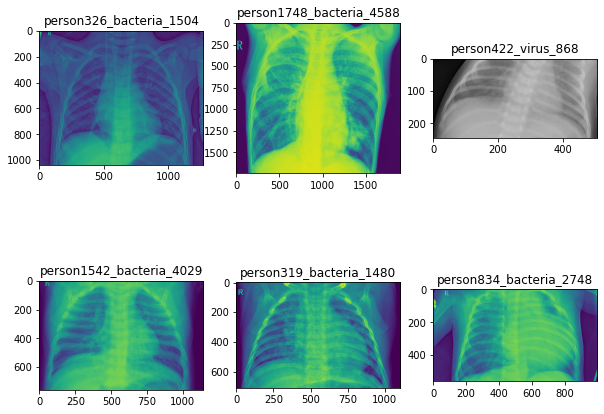

In [38]:
plot_images(type="pneumonia", num=6)


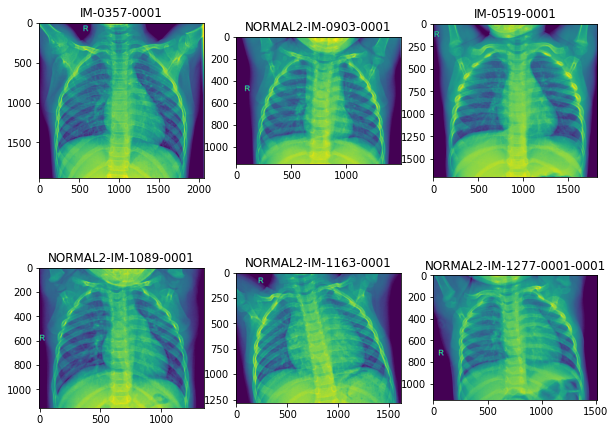

In [39]:
plot_images(type="normal", num=6)

## **Modeling**

**Pre-Trained Model w/o Transfer Learning**

In [41]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

In [42]:
pre_model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 2s 0us/step


In [43]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))


40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


# **Data Preparation**


In [46]:
from keras.preprocessing.image import ImageDataGenerator

In [47]:
batch_size=163


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #Create image generator in the abstract

In [48]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [49]:
#Create validation data generator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 624 images belonging to 2 classes.


In [50]:
#Create validation test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 16 images belonging to 2 classes.


# **Model Training**


In [51]:
import keras

In [52]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model

87916544/87910968 [==============================] - 1s 0us/step


In [53]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [54]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
32/32 [==============================] - 289s 9s/step - loss: 0.5119 - accuracy: 0.8629 - val_loss: 0.3785 - val_accuracy: 0.8670
Epoch 2/5
32/32 [==============================] - 283s 9s/step - loss: 0.2013 - accuracy: 0.9270 - val_loss: 0.7240 - val_accuracy: 0.7244
Epoch 3/5
32/32 [==============================] - 283s 9s/step - loss: 0.1768 - accuracy: 0.9337 - val_loss: 0.4546 - val_accuracy: 0.8317
Epoch 4/5
32/32 [==============================] - 282s 9s/step - loss: 0.1629 - accuracy: 0.9365 - val_loss: 0.3573 - val_accuracy: 0.8782
Epoch 5/5
32/32 [==============================] - 284s 9s/step - loss: 0.1522 - accuracy: 0.9429 - val_loss: 0.3851 - val_accuracy: 0.8638


# Training curve

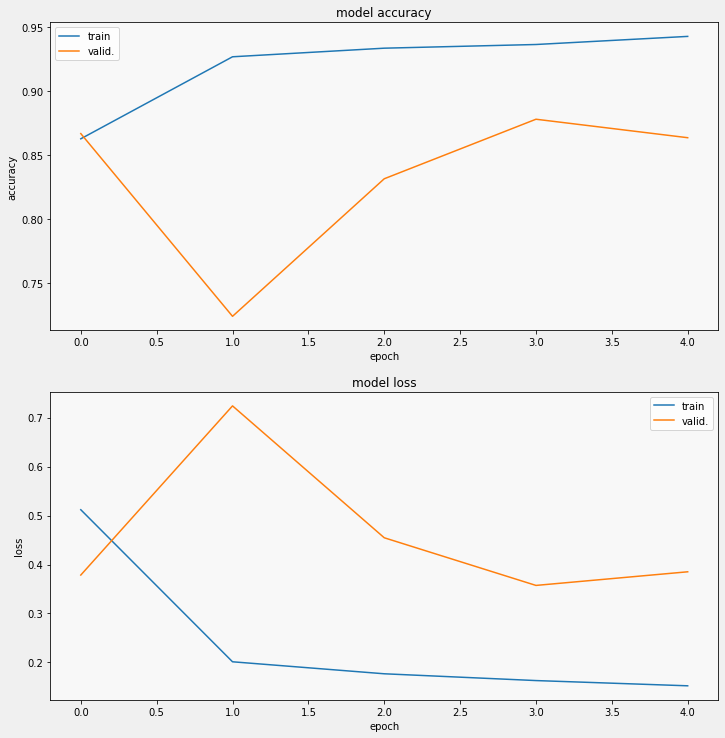

In [56]:
display_training_curves(fit_history.history['accuracy'], fit_history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [57]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Loss: 0.47888749837875366
Accuracy: 0.8125


In [58]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [59]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

Instructions for updating:
Please use Model.predict, which supports generators.


array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [60]:
#Generate true labels
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Prediction: Pneumonia


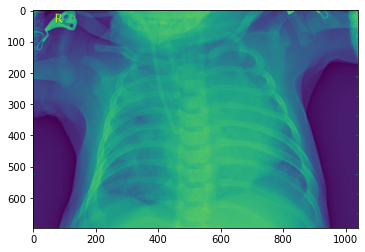

In [79]:
filename = "/content/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg"

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = print("Prediction:", predicton)
plt.title(title_text)
imgplot=plt.imshow(img)